# Project 1 : 직접 고른 이미지로 SRGAN 실험하기

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

## Project 1-1

#### 1. 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러오기

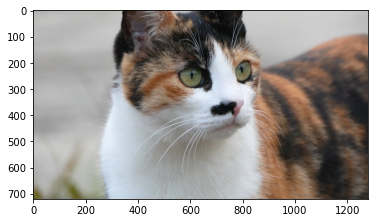

In [2]:
cat = cv2.imread('aiffel/image/cat.jpg')
cat = cv2.cvtColor(cat, cv2.COLOR_BGR2RGB)
plt.imshow(cat)

#### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄이기

In [3]:
lr_cat = cv2.resize(
    cat, 
    dsize=(cat.shape[1]//4, cat.shape[0]//4),
    interpolation=cv2.INTER_CUBIC
)

#### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성

In [4]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [5]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [6]:
sr_cat = apply_srgan(lr_cat)

#### 4. lr_cat bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘리기

In [7]:
hr_cat = cv2.resize(
    lr_cat, 
    dsize=(lr_cat.shape[1]*4, lr_cat.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
)

#### 5. 고해상도 사진 시각화

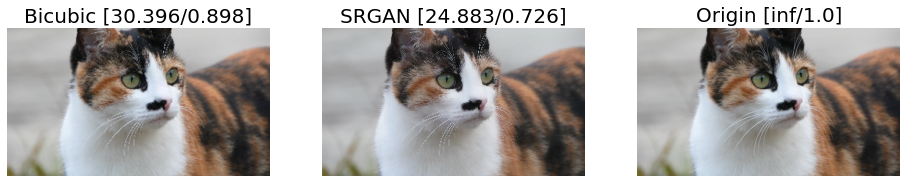

In [14]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

images = [hr_cat, sr_cat, cat]
titles = ["Bicubic", "SRGAN", "Origin"]

psnr = [round(peak_signal_noise_ratio(cat, i), 3) for i in images]
ssim = [round(structural_similarity(cat, i, multichannel=True), 3) for i in images]

plt.figure(figsize=(16,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=20)
    plt.axis('off')

#### 6. DIV2K 데이터셋에서 학습된 모델의 Super Resolution 결과

In [19]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srcnn.h5'
srcnn = tf.keras.models.load_model(model_file)

def apply_srcnn(image):
    sr = srcnn.predict(image[np.newaxis, ...]/255.)
    sr[sr > 1] = 1
    sr[sr < 0] = 0
    sr *= 255.
    return np.array(sr[0].astype(np.uint8))

In [20]:
src_cat = apply_srcnn(cat)

In [21]:
print("PSNR :", peak_signal_noise_ratio(src_cat, cat))
print("SSIM :", structural_similarity(src_cat, cat, multichannel=True))

PSNR : 25.52406984596113
SSIM : 0.8413469937644646


## Project 1-2

#### 1. 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러오기

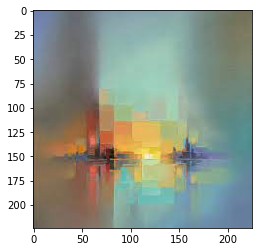

In [9]:
scene = cv2.imread('aiffel/image/image.jpeg')
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
plt.imshow(scene)

#### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성하기

In [10]:
sr_scene = apply_srgan(scene)

#### 3. scene에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘리기

In [11]:
hr_scene = cv2.resize(
    scene, 
    dsize=(scene.shape[1]*4, scene.shape[0]*4),
    interpolation=cv2.INTER_CUBIC
)

#### 4. 고해상도 사진 시각화

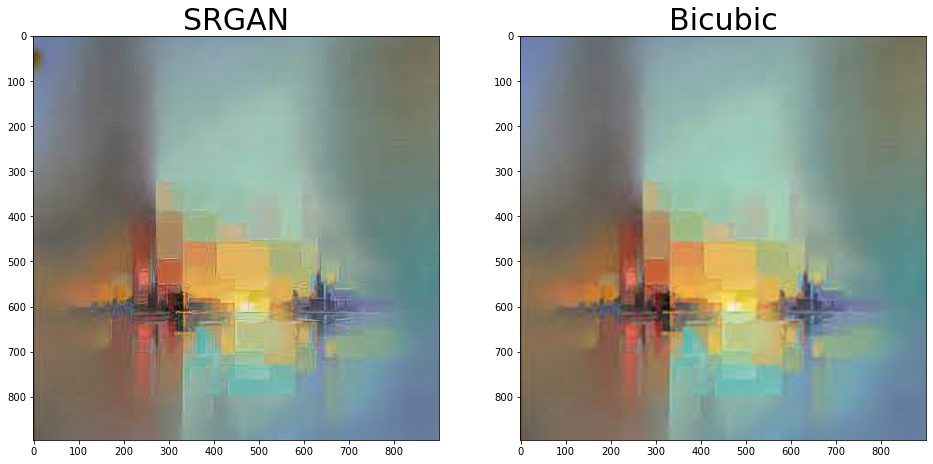

In [18]:
images = [sr_scene, hr_scene]
labels = ["SRGAN", "Bicubic"]

plt.figure(figsize=(16,16))
for i in range(2):
    plt.subplot(1,2,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

#### 5. DIV2K 데이터셋에서 학습된 모델의 Super Resolution 결과

In [22]:
src_scene = apply_srcnn(scene)

In [34]:
print("PSNR :", peak_signal_noise_ratio(src_scene, scene))
print("SSIM :", structural_similarity(src_scene, scene, multichannel=True))

PSNR : 27.676038049175165
SSIM : 0.8654938285598216


## Project 2 : SRGAN을 이용해 고해상도 gif 생성하기

#### 1. gif 파일 불러오기

In [24]:
gif = cv2.VideoCapture("aiffel/image/city_night_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


#### 2. 프레임별 Super Resolution 진행하기

In [25]:
def apply_bicubic_hr(image):
    image = cv2.resize(
        image, 
        dsize=(image.shape[1]*4, image.shape[0]*4),
        interpolation=cv2.INTER_CUBIC
    )
    return image

In [26]:
frames_hr = []
for f in frames:
    frames_hr.append(apply_bicubic_hr(f))

In [27]:
frames_sr = []
for f in frames:
    frames_sr.append(apply_srgan(f))

#### 3. 프레임을 합쳐 gif 만들기

In [28]:
import imageio

In [29]:
imageio.mimsave("aiffel/image/city_night_hr.gif", frames_hr)

In [30]:
imageio.mimsave("aiffel/image/city_night_sr.gif", frames_sr)

#### 4. Jupyter notebook에 gif 표시하기

In [41]:
# from IPython.display import Image as show_gif

# show_gif("aiffel/image/city_night_lr.gif", width=800)

In [42]:
# show_gif("aiffel/image/city_night_hr.gif", width=800)

In [43]:
# show_gif("aiffel/image/city_night_sr.gif", width=800)

# 결과

최근 인터넷에서 유행하던 화질 안 좋은 사진 좋게 바꾸는 알고리즘에 대해 궁금했었는데 이번 노드를 통해 배우고 실습하게 되어서 재밌었다.  
   
SRGAN과 Bicubic 보간 둘다 좋은 결과를 가져오는 것 같다.   